# Анализ пользовательского поведения в мобильном приложении

## Описание проекта

Есть стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.  
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.  

## План работ
1. [__Изучение общей информации__](#open)   
   - Путь к файлу: /datasets/logs_exp.csv 
2. [__Подготовка данных__](#preparation)
   - Заменим названия столбцов на удобные;
   - Проверим пропуски и типы данных. Откорректируем, если нужно;
   - Добавим столбец даты и времени, а также отдельный столбец дат;
3. [__Изучение и проверка данных__](#check)
   - Сколько всего событий в логе?
   - Сколько всего пользователей в логе?
   - Сколько в среднем событий приходится на пользователя?
   - Данными за какой период мы располагаем? Найдём максимальную и минимальную дату. Построим гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные. Данными за какой период времени мы располагаем на самом деле?
   - Много ли событий и пользователей мы потеряли, отбросив старые данные?
   - Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.
4. [__Изучение воронки событий__](#funnel)
   - Посмотрим, какие события есть в логах, как часто они встречаются.
   - Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.
   - Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
   - По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
   - На каком шаге теряем больше всего пользователей?
   - Какая доля пользователей доходит от первого события до оплаты?
5. [__Изучение результатов эксперимента__](#aab)
   - Сколько пользователей в каждой экспериментальной группе?
   - Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
   - Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?
   - Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.  
6. [__Вывод__](#result)
___
### Описание данных
Каждая запись в логе — это действие пользователя, или событие.  
- __EventName__ — название события;
- __DeviceIDHash__ — уникальный идентификатор пользователя;
- __EventTimestamp__ — время события;
- __ExpId__ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
colors =["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
sns.set_palette(sns.color_palette(colors))
import re
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mth

<a name='open'></a>
## Изучение общей информации

In [2]:
df = pd.read_csv('../../datasets/logs_exp.csv', sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

##### Комментарий:

Перед нами логи событий приложения с указанием наименования события, ID пользователя, информацией о времени события и номером эксперимента (группы).

<a name='preparation'></a>
## Подготовка данных

In [3]:
df.columns = ['event_name', 'user_id', 'datetime', 'group']
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


event_name              user_id            datetime  group  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   

         date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

##### Комментарий:

Мы заменили названия данных на удобные, удалили дубликаты, поменяли тип данных в графе с информацией о дате и времени и добавили столбец где указанна только дата.  

- __event_name__ — название события;
- __user_id__ — уникальный идентификатор пользователя;
- __datetime__ — дата и время события;
- __group__ — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
- __date__ — дата события. 

<a name='check'></a>
## Изучение и проверка данных

Перед нами логи за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17.

Всего событий в логе 243713.

Всего пользователей в логе 7551.

В среднем на пользователя приходится 20 событий.


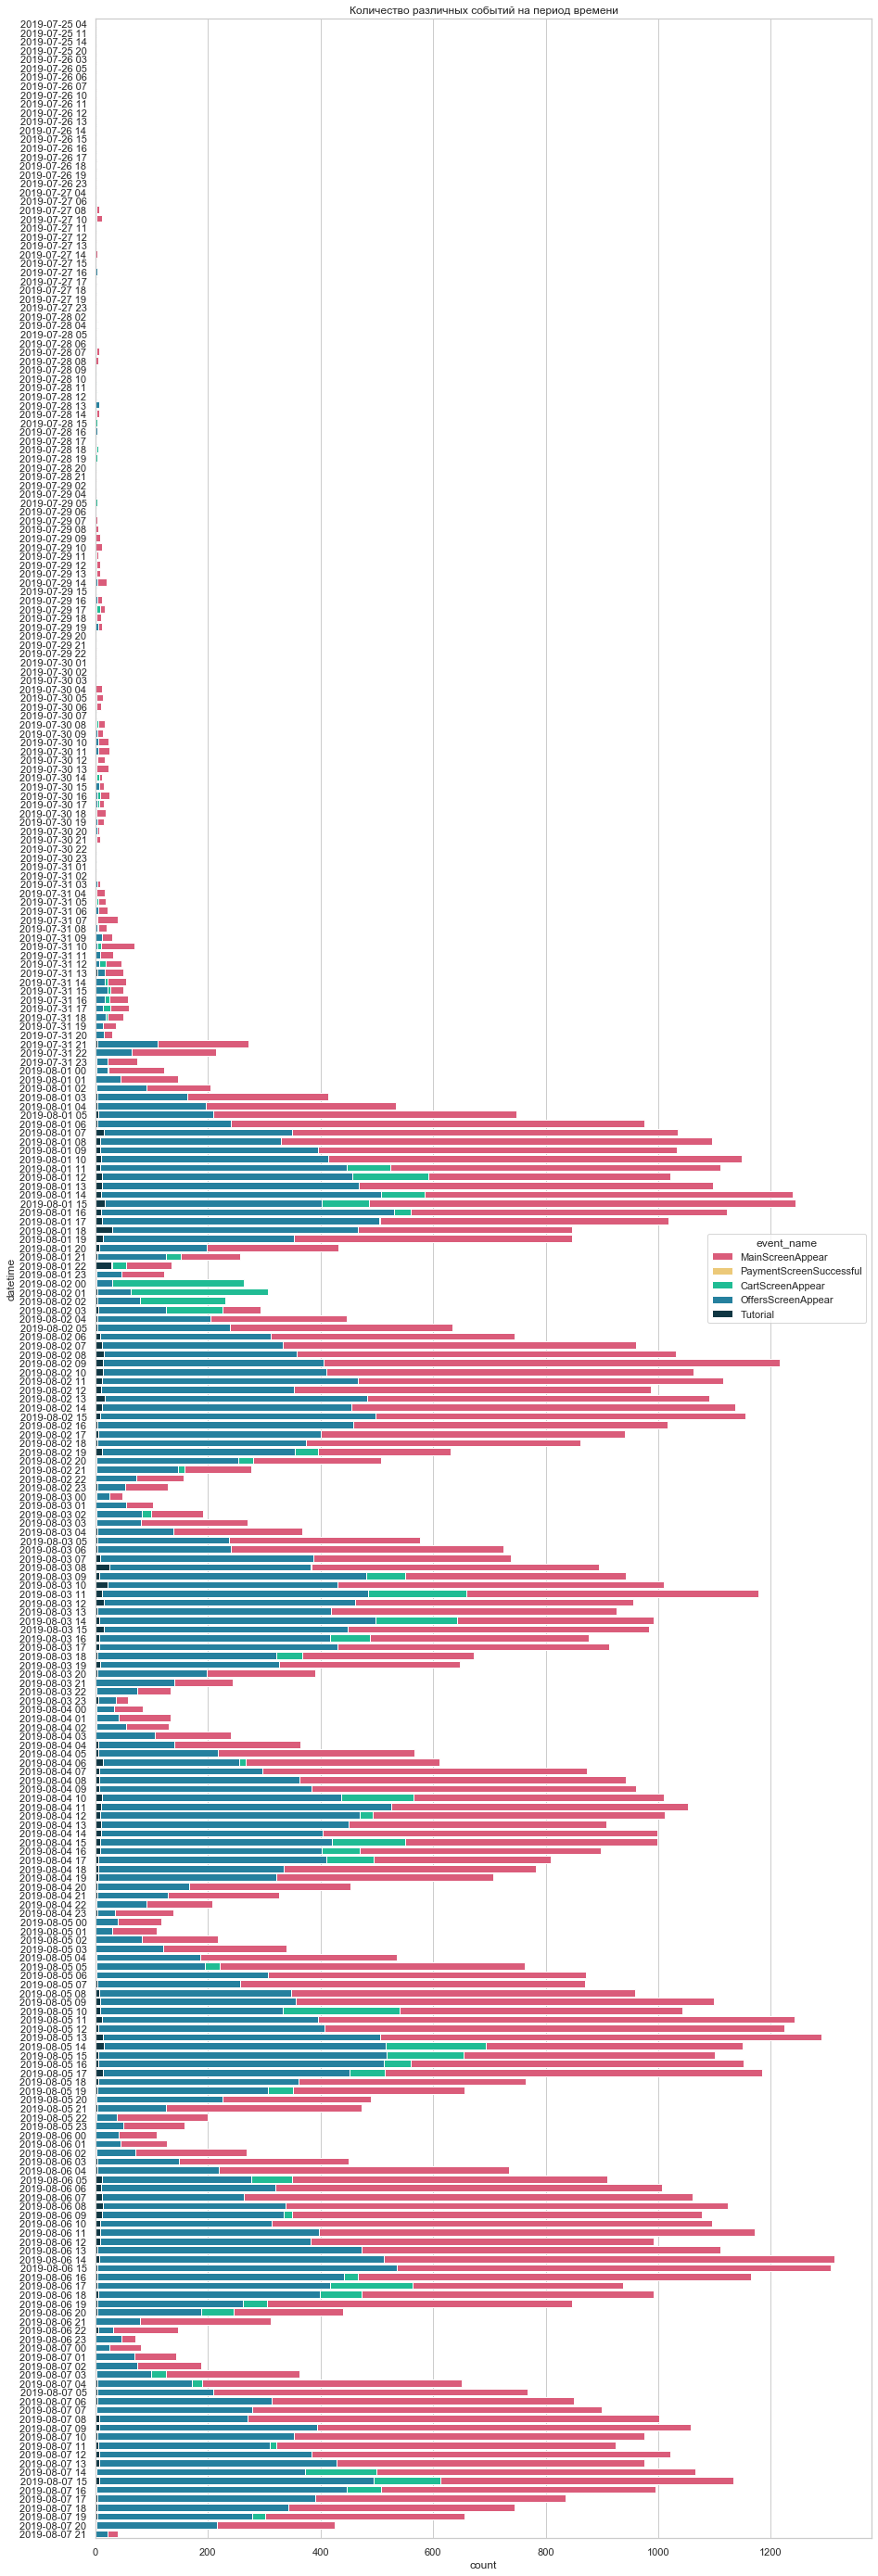

In [4]:
print('Перед нами логи за период с {} по {}.'.format(df['datetime'].min(), df['datetime'].max()))
print('')
print('Всего событий в логе {}.'.format(df['user_id'].count()))
print('')
print('Всего пользователей в логе {}.'.format(df['user_id'].nunique()))
print('')
print('В среднем на пользователя приходится {} событий.'
      .format(int(df.groupby('user_id')['event_name'].agg('count').median())))
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=df['datetime'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=df, dodge=False)
ax.set_title('Количество различных событий на период времени')
plt.show()

##### Комментарий:

Перед нами логи за период с 2019-07-25 04:43:36 по 2019-08-07 21:15:17. Всего событий в логе 243713. Всего пользователей в логе 7551. В среднем на пользователя приходится 20 событий.  

Глядя на гистограмму по дате и времени, мы видим, что у нас одинаково полные данные только за период с 2019-07-31 21:00 по 2019-08-07 21:00. 

___Отбросим неполные данные и оставим только период с 2019-07-31 21 часа:___

Дальнейший анализ будет проводиться для данных в период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.

Всего событий в логе за актуальный период 241724.

Всего пользователей в логе за актуальный период 7538.

В среднем на пользователя приходится 19 событий.


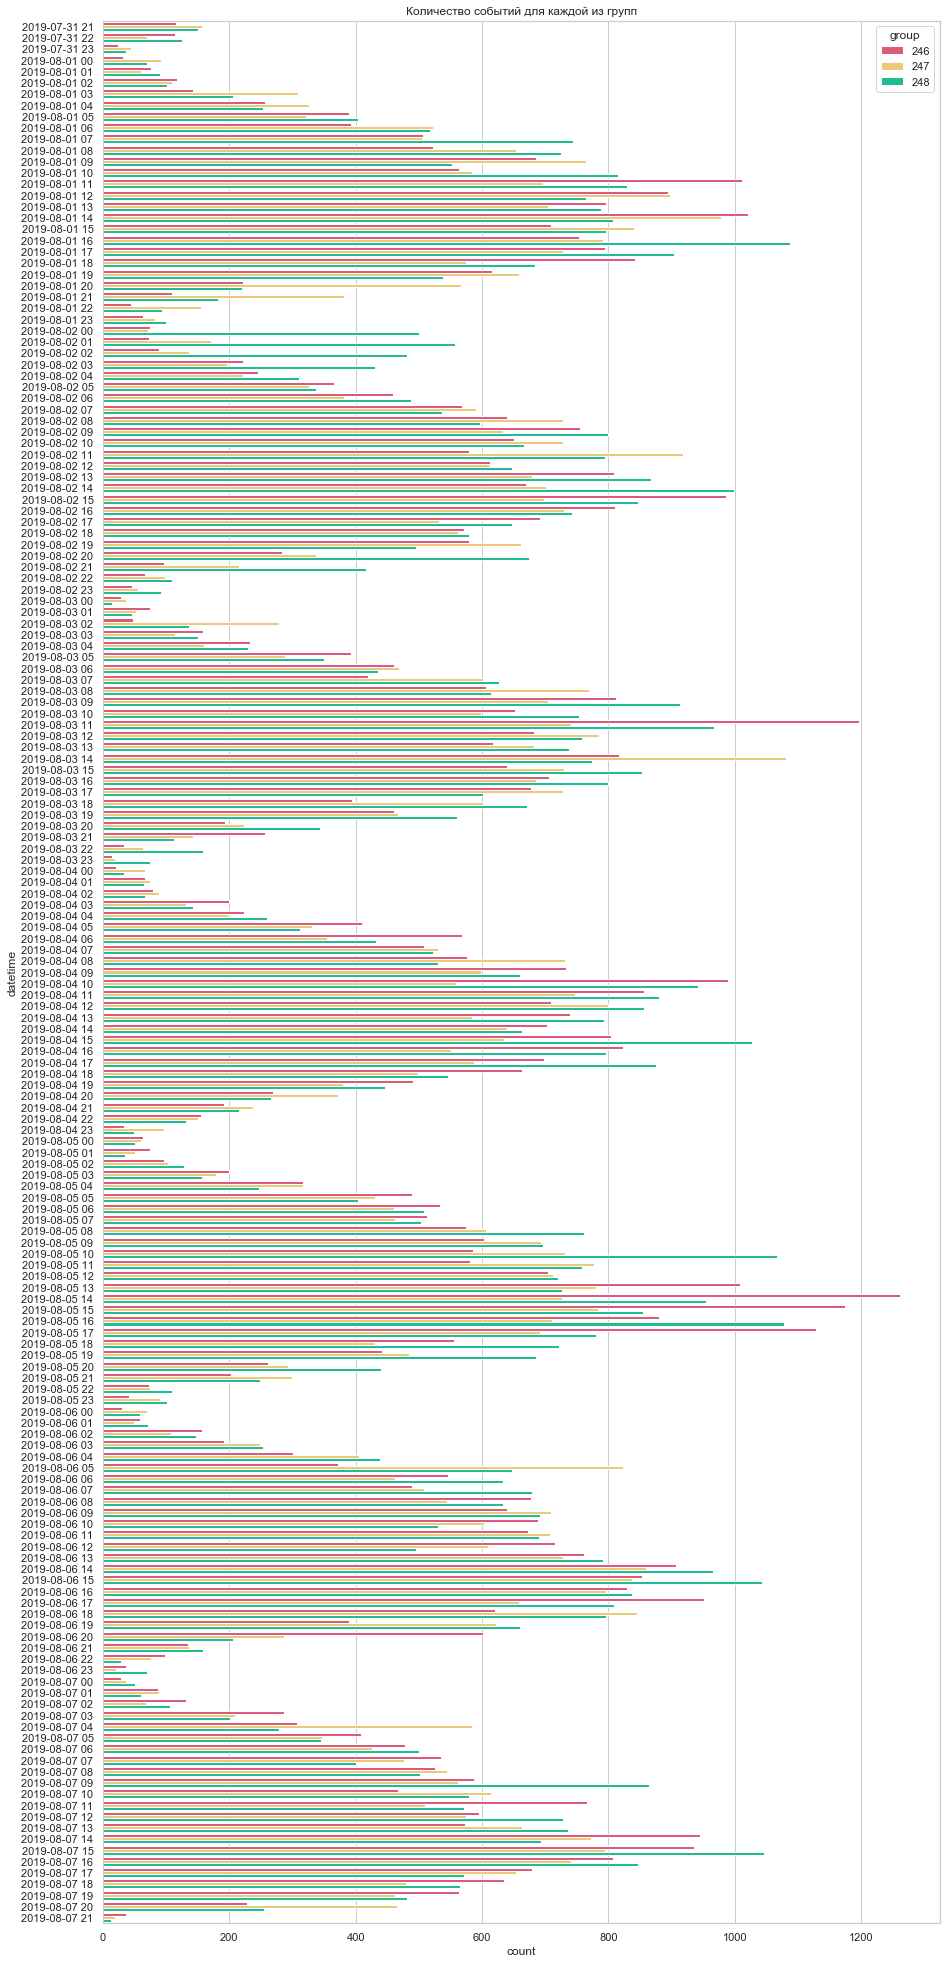

In [5]:
df = df['2019-07-31 21:00' <= df['datetime']]
print('Дальнейший анализ будет проводиться для данных в период с {} по {}.'.format(df['datetime'].min(), df['datetime'].max()))
print('')
print('Всего событий в логе за актуальный период {}.'.format(df['user_id'].count()))
print('')
print('Всего пользователей в логе за актуальный период {}.'.format(df['user_id'].nunique()))
print('')
print('В среднем на пользователя приходится {} событий.'
      .format(int(df.groupby('user_id')['event_name'].agg('count').median())))
plt.figure(figsize=(15, 35))
ax = sns.countplot(y=df['datetime'].dt.strftime('%Y-%m-%d %H'),  data=df, hue='group')
ax.set_title('Количество событий для каждой из групп')
plt.show()

##### Комментарий:

Дальнейший анализ будет проводиться для данных в период с 2019-07-31 21:00:57 по 2019-08-07 21:15:17.  
- Событий в логе за актуальный период 241724.
- Пользователей в логе за актуальный период 7538.
- В среднем на пользователя приходится 19 событий.  

Отбросив неполноценные данные мы потеряли не более одного процента событий, также на гистограмме видно, что у нас присутствуют данные всех групп.

<a name='funnel'></a>
## Изучение воронки событий

___Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте:___

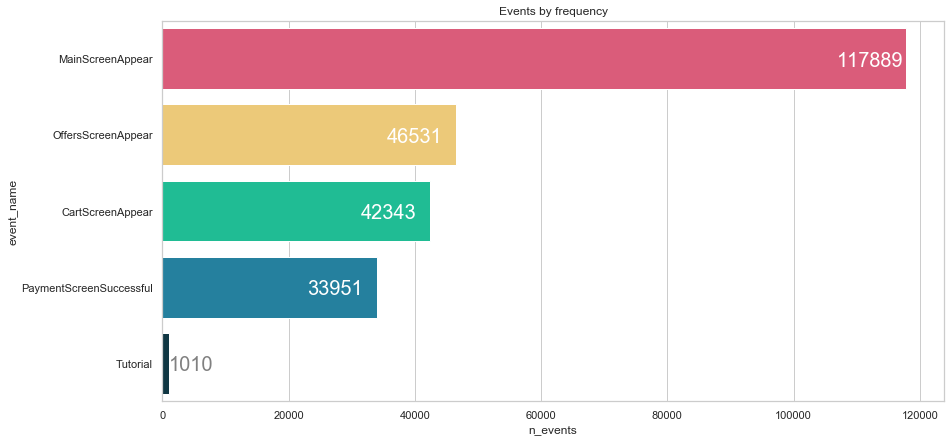

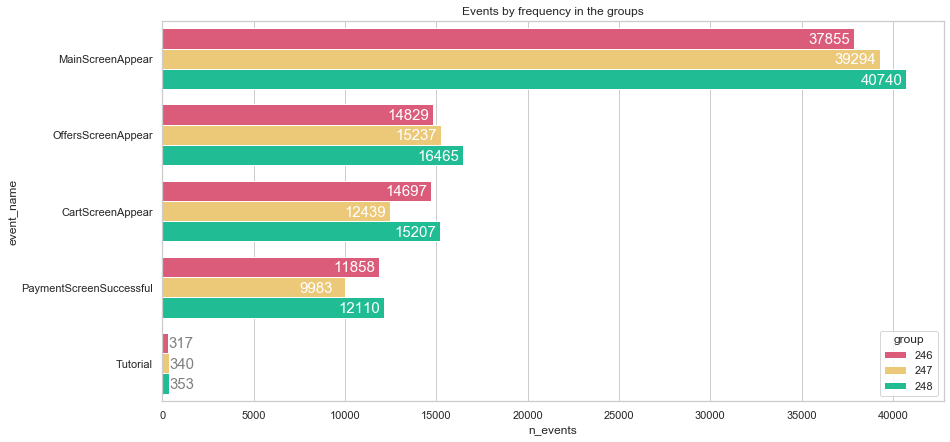

In [6]:
events = df.groupby('event_name')['user_id'].agg(['count', 'nunique']).reset_index()
events.columns =['event_name', 'n_events', 'n_users']
n_users = {'all': df['user_id'].nunique(), 
           246: df[df['group']==246]['user_id'].nunique(),
           247: df[df['group']==247]['user_id'].nunique(),
           248: df[df['group']==248]['user_id'].nunique(),
           '246+247': df[(df['group']==246) | (df['group']==247)]['user_id'].nunique()}
plt.figure(figsize=(14, 7))
order = events.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
ax = sns.barplot(y='event_name', x='n_events', order = order,  data=events)
ax.set_title('Events by frequency')
for i in ax.patches:
    if i.get_width() > 20000:
        ax.text(i.get_width()-11000, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.5, 
                str(int(i.get_width())), fontsize=20, color='grey')
plt.show()

event_pivot=df.pivot_table(index=['event_name','group'], values='user_id', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns= ['event_name','group', 'n_events', 'n_users']

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_events', order = order, hue='group', data=event_pivot)
ax.set_title('Events by frequency in the groups')
for i in ax.patches:
    if i.get_width() > 9000:
        ax.text(i.get_width()-2500, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.2, 
                str(int(i.get_width())), fontsize=15, color='grey')
plt.show()

##### Комментарий:

- Самое частое событие это появление основного экрана(MainScreenAppear) случалось 117889 раз.
- Второе по популярности событие это появление экрана с каталогом продуктов(OffersScreenAppear) случалось 46531 раз.
- Третье по популярности событие это появление экрана с корзиной(CartScreenAppear) случалось 42343 раза.
- Четвёртое по популярности событие это появление экрана с успешной оплатой(PaymentScreenSuccessful) случалось 33951 раз.
- Пятое по популярности событие это открытие руководства пользователя(Tutorial) случалось 1010 раз.

___Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие:___

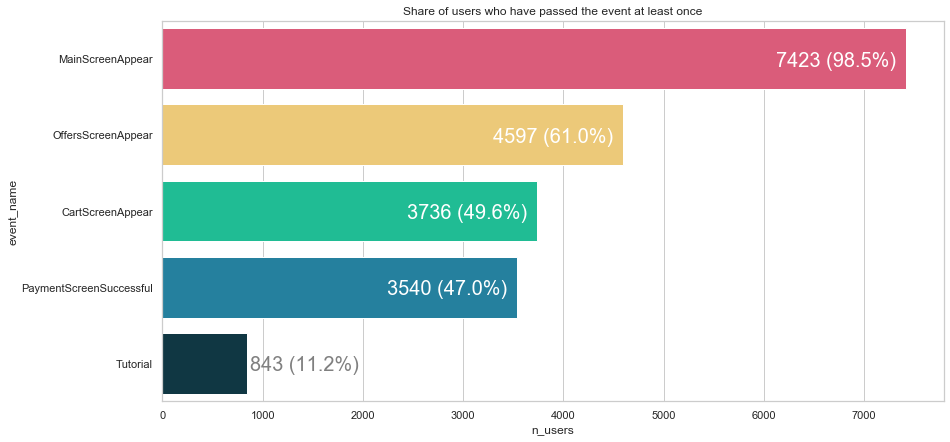

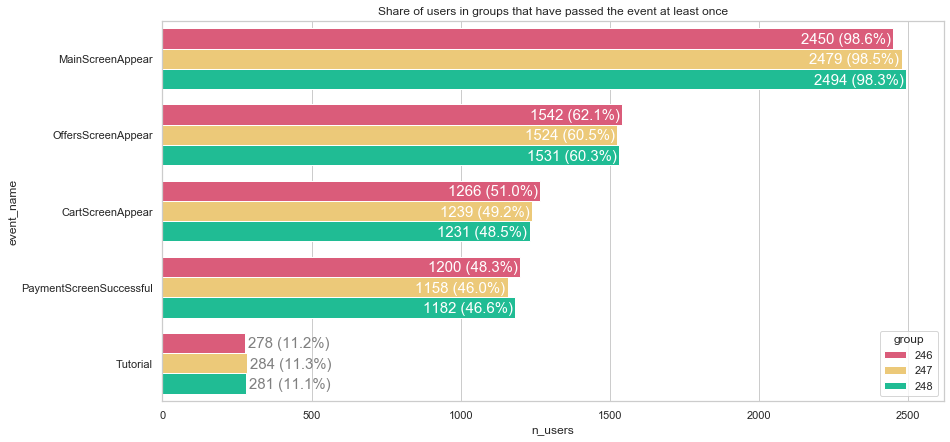

In [7]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_users', order = order,  data=events)
ax.set_title('Share of users who have passed the event at least once')
for i in ax.patches:
    if i.get_width() > 3000:
        ax.text(i.get_width()-1300, i.get_y()+0.5, 
            str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users['all']), fontsize=20, color='white')
    else:
        ax.text(i.get_width()+30, i.get_y()+0.5, 
            str(int(i.get_width()))+' ({:.1%})'.format(i.get_width() / n_users['all']), fontsize=20, color='grey')
plt.show()

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_users', order = order, hue='group', data=event_pivot)
ax.set_title('Share of users in groups that have passed the event at least once')
for i,v in enumerate(ax.patches):
    if i < 5:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[246]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[246]),
                    fontsize=15, color='grey')
    if 5 <= i < 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[247]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[247]),
                    fontsize=15, color='grey')
    if i >= 10:
        if v.get_width() > 1000:
            ax.text(v.get_width()-310, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[248]),
                    fontsize=15, color='white')
        else:
            ax.text(v.get_width()+10, v.get_y()+0.2, 
                str(int(v.get_width()))+' ({:.1%})'.format(v.get_width() / n_users[248]),
                    fontsize=15, color='grey')
plt.show()

##### Комментарий:

- 7423 пользователя хотя бы раз открывали главную страницу приложения(MainScreenAppear) это 98,5% всех пользователей.
  - Возможно оставшиеся пользователи не смогли попасть на главную страницу из-за ошибок/некорректного отображения.
- 4597 пользователей хотя бы раз открывали страницу с каталогом товаров(OffersScreenAppear) это 61% всех пользователей.
  - 39% пользователей не увидели даже каталог товаров стоит выяснить причину, возможно приложение не на всех устройствах работает корректно.
- 3736 пользователей хотя бы раз открывали корзину(CartScreenAppear) это 49,6% всех пользователей.
- 3540 пользователей хотя бы раз попадали на страницу с успешной оплатой(PaymentScreenSuccessful) это 47% всех пользователей.
- 843 пользователя хотя бы раз открывали руководство пользователя(Tutorial) это 11,2% всех пользователей.

___Предположим, что пользователь___ 
- ___сначала открывает главную страницу приложения(MainScreenAppear) →___ 
- ___потом в каталоге выбирает товары(OffersScreenAppear) →___ 
- ___кладёт их в корзину(CartScreenAppear) →___ 
- ___и оплачивает(PaymentScreenSuccessful).___  

___По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (не учитывая последовательность событий):___

In [8]:
order = (events[events['event_name'] != 'Tutorial']
         .sort_values('n_events', ascending=False)['event_name']
         .reset_index(drop=True))
groups = [246, 247, 248]
simple_funnel = {}
for group in groups:
    simple_funnel[group] =[]
    for event in order:
        simple_funnel[group].append(df[(df['group'] == group) & (df['event_name'] == event)]['user_id'].nunique())
fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['event_name']),
        x = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['n_users']),
        textposition = "inside",
        textinfo = "value+percent previous",
        marker = {"color": colors[i]},
        connector = {"fillcolor": '#bde0eb'},
        insidetextfont = {'color': 'white', 'size': 14}))

fig.show()

##### Комментарий:

Глядя на эту воронку мы видим, что больше всего пользователей (37% для группы 246 и 39% для групп 247 и 248) уходят от нас посмотрев на главный экран(MainScreenAppear) и даже без перехода к каталогу товаров(OffersScreenAppear). Это может говорить о том что интерфейс основной страницы неудобен или некорректно отображается на части устройств, хорошо бы запросить данные о моделях устройств и проверить нет ли зависимости оттока пользователей от устройств.  
От первого события до оплаты доходит меньше половины пользователей(49%/46,7%/47,4% для групп 246/247/248 соответственно.) 

___Теперь посмотрим на воронку с учётом предполагаемой последовательности событий:___
- ___сначала открывает главную страницу приложения(MainScreenAppear) →___ 
- ___потом в каталоге выбирает товары(OffersScreenAppear) →___ 
- ___кладёт их в корзину(CartScreenAppear) →___ 
- ___и оплачивает(PaymentScreenSuccessful).___  

In [9]:
users = df[df['event_name'] != 'Tutorial'].pivot_table(
        index=['user_id', 'group'], 
        columns='event_name', 
        values='datetime',
        aggfunc='min').reset_index()

funnel ={}
for group in groups:
    funnel[group] =[]
    step_1 = (users['group']==group) & (~users['MainScreenAppear'].isna())
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])
    funnel[group].append(users[step_1].shape[0])
    funnel[group].append(users[step_2].shape[0])
    funnel[group].append(users[step_3].shape[0])
    funnel[group].append(users[step_4].shape[0])
    

fig = go.Figure()
for i, group in enumerate(groups):
    fig.add_trace(go.Funnel(
        name = str(group),
        y = (event_pivot[(event_pivot['group'] == group) & (event_pivot['event_name'] != 'Tutorial')]
             .sort_values('n_users', ascending=False)['event_name']),
        x = funnel[group],
        textposition = "inside",
        textinfo = "percent previous",
        constraintext='outside',
        textangle = 90,
        marker = {"color": colors[i]},
        connector = {"fillcolor": '#bde0eb'},
        insidetextfont = {'color': 'white'}))

fig.show()

##### Комментарий:

Предполагаемой последовательности шагов следует многие пользователи, но далеко не все. Для сравнения от первого события до оплаты по этому пути дошло 5,9%/5,9%/6,7% для групп 246/247/248 соответственно (в экспериментальной группе, с изменённым шрифтом, этот паттерн чуть больше распространён).  
Это нам говорит о том, что если несколько способов дойти до оплаты в приложении, например возможность мгновенной оплаты товара без перехода в корзину и т.п.

<a name='aab'></a>
## Изучение результатов эксперимента

In [10]:
print('Для A/A/B-теста пользователей разбили на 3 группы: '
      '2 контрольные(246 и 247) со старыми шрифтами и одну экспериментальную(248) — с новыми.')
print('')
for group in groups:
    n_users
    print('В {} группе {} пользователей'.format(group, n_users[group]))
    print('')

Для A/A/B-теста пользователей разбили на 3 группы: 2 контрольные(246 и 247) со старыми шрифтами и одну экспериментальную(248) — с новыми.

В 246 группе 2484 пользователей

В 247 группе 2517 пользователей

В 248 группе 2537 пользователей



___Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.___

In [11]:
simple_funnel = pd.DataFrame(simple_funnel)
simple_funnel['246+247'] = simple_funnel[246] + simple_funnel[247]
simple_funnel['event_name'] = order
def z_value_diff(first_group, second_group, alpha, color):
    for i in simple_funnel.index:
        alpha = alpha
        p1 = simple_funnel[first_group][i] / n_users[first_group]
        # пропорция успехов во второй группе:
        p2 = simple_funnel[second_group][i] / n_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((simple_funnel[first_group][i] + simple_funnel[second_group][i]) / 
                      (n_users[first_group] + n_users[second_group]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/n_users[first_group] + 1/n_users[second_group]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(simple_funnel['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
    fig = go.Figure()
    for i, group in enumerate([first_group, second_group]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = order,
            x = simple_funnel[group],
            textposition = "inside",
            textinfo = "value+percent initial",
            marker = {"color": colors[i+color]},
            connector = {"fillcolor": '#bde0eb'},
            insidetextfont = {'color': 'white', 'size': 14}))

    fig.show()
z_value_diff(246,247,0.05,0)


MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### Комментарий:

Ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными.

___Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.___  
_Группы 246 и 248:_

In [12]:
z_value_diff(246,248,0.05,1)

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### Комментарий:

Значимой разницы между контрольной группой 246 и экспериментальной группой не выявлено.

___Группы 247 и 248:___

In [13]:
z_value_diff(247,248,0.05,2)

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### Комментарий:

Значимой разницы между контрольной группой 246 и экспериментальной группой не выявлено.

___Теперь сравним  контрольные 246 и 247, объединенные в одну группу, с экспериментальной 248-ой:___

In [14]:
z_value_diff('246+247',248,0.05,3)

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



##### Комментарий:

Сравнение результатов с объединенной контрольной группой также не показало значимой разницы.

<a name='result'></a>
## Вывод:

Анализируя гистограмму по дате и времени, мы [приняли решение](#check) отбросить неполные данные и оставить только период с 2019-07-31 21 часа.  

При [исследовании воронки событий](#funnel) мы выяснили, что от первого события до оплаты доходит меньше половины пользователей (49%/46,7%/47,4% для групп 246/247/248 соответственно.)  
Только 98,5% всех пользователей хотя бы раз открывали главную страницу приложения (возможно оставшиеся пользователи не смогли попасть на главную страницу из-за ошибок/некорректной работы приложения).  
Только 4597 пользователей хотя бы раз открывали страницу с каталогом товаров (39% пользователей не увидели даже каталог товаров необходимо выяснить причину, возможно приложение не на всех устройствах работает корректно).

Мы [провели 16 проверок статистических гипотез](#aab) с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.  

При уровне значимости 0.1 только одна из проверок покажет значимую разницу, между контрольной группой 246 и экспериментальной в доле перехода пользователей в корзину(CartScreenAppear), но эта разница будет не в пользу нашей экспериментальной группы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05.  

__Исходя из результатов данного A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Что можно считать успехом, т.к. целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.__